Code repurposed from Kaggle [https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-cryptocurrencies]

## import dependencies

In [1]:
import pandas as pd
import pandas_datareader as web
import numpy as np
from pathlib import Path
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

## load and inspect data

In [2]:
crypto_currency = 'DOGE'
against_currency = 'USD'

start = dt.datetime(2014,1,1)
end = dt.datetime.now()

base_df = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end)
base_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-16,0.000299,0.000260,0.000293,0.000268,1.463600e+06,0.000268
2014-09-17,0.000325,0.000267,0.000268,0.000298,2.215910e+06,0.000298
2014-09-18,0.000307,0.000275,0.000298,0.000277,8.835630e+05,0.000277
2014-09-19,0.000310,0.000267,0.000276,0.000292,9.930040e+05,0.000292
2014-09-20,0.000299,0.000284,0.000293,0.000288,5.391400e+05,0.000288
...,...,...,...,...,...,...
2021-06-13,0.336927,0.320087,0.323903,0.332085,1.613812e+09,0.332085
2021-06-14,0.330495,0.316976,0.326785,0.328381,1.687965e+09,0.328381
2021-06-15,0.321393,0.305485,0.320378,0.307761,1.391721e+09,0.307761


In [3]:
base_df['Spread'] = base_df.High - base_df.Low
base_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2463 entries, 2014-09-16 to 2021-06-19
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2463 non-null   float64
 1   Low        2463 non-null   float64
 2   Open       2463 non-null   float64
 3   Close      2463 non-null   float64
 4   Volume     2463 non-null   float64
 5   Adj Close  2463 non-null   float64
 6   Spread     2463 non-null   float64
dtypes: float64(7)
memory usage: 153.9 KB


## Plot the closing value of Dogecoin over time

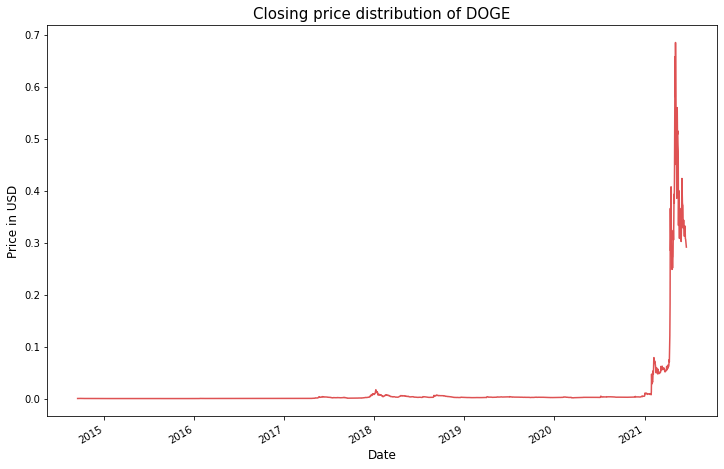

In [4]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(y = base_df.Close.values, x=base_df.index.values, alpha=0.8, color=color[3])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Closing price distribution of DOGE", fontsize=15)
plt.show()

## Candlestick chart

In [5]:
import matplotlib.ticker as mticker
import mplfinance as mpf

#base_df['Date_mpl'] = base_df['Date'].apply(lambda x: mdates.date2num(x))

temp_base_df = base_df.copy(deep=False)
#temp_base_df = temp_base_df.set_index(['Date'])
temp_base_df = temp_base_df.drop(['Spread'], axis=1)
temp_base_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-16,0.000299,0.000260,0.000293,0.000268,1.463600e+06,0.000268
2014-09-17,0.000325,0.000267,0.000268,0.000298,2.215910e+06,0.000298
2014-09-18,0.000307,0.000275,0.000298,0.000277,8.835630e+05,0.000277
2014-09-19,0.000310,0.000267,0.000276,0.000292,9.930040e+05,0.000292
2014-09-20,0.000299,0.000284,0.000293,0.000288,5.391400e+05,0.000288
...,...,...,...,...,...,...
2021-06-13,0.336927,0.320087,0.323903,0.332085,1.613812e+09,0.332085
2021-06-14,0.330495,0.316976,0.326785,0.328381,1.687965e+09,0.328381
2021-06-15,0.321393,0.305485,0.320378,0.307761,1.391721e+09,0.307761


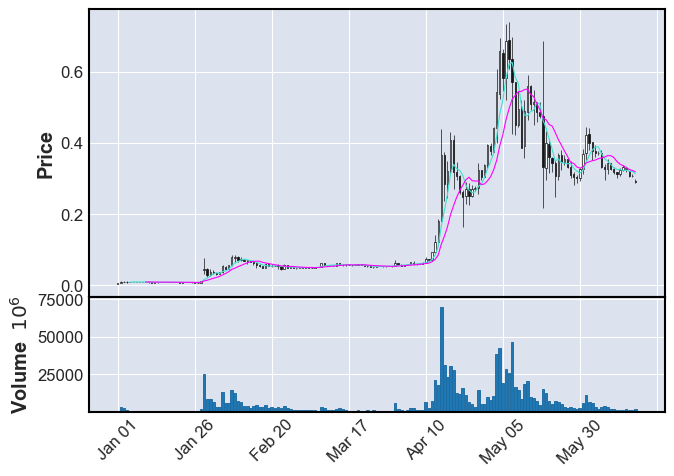

In [6]:
mpf.plot(temp_base_df.loc['2021-1-1':], type='candle', mav=(5,10), volume=True)

## Future Price Prediction

In [7]:
from fbprophet import Prophet

In [8]:
base_df

,High,Low,Open,Close,Volume,Adj Close,Spread
Date,,,,,,,
2014-09-16,0.000299,0.000260,0.000293,0.000268,1.463600e+06,0.000268,0.000039
2014-09-17,0.000325,0.000267,0.000268,0.000298,2.215910e+06,0.000298,0.000058
2014-09-18,0.000307,0.000275,0.000298,0.000277,8.835630e+05,0.000277,0.000032
2014-09-19,0.000310,0.000267,0.000276,0.000292,9.930040e+05,0.000292,0.000043
2014-09-20,0.000299,0.000284,0.000293,0.000288,5.391400e+05,0.000288,0.000015
...,...,...,...,...,...,...,...
2021-06-13,0.336927,0.320087,0.323903,0.332085,1.613812e+09,0.332085,0.016840
2021-06-14,0.330495,0.316976,0.326785,0.328381,1.687965e+09,0.328381,0.013519
2021-06-15,0.321393,0.305485,0.320378,0.307761,1.391721e+09,0.307761,0.015908


In [9]:
price_predict_df = base_df['Close'].copy(deep=False).reset_index()
price_predict_df.columns = ["ds", "y"]
price_predict_df = price_predict_df[price_predict_df['ds']>'2021-1-1']
price_predict_df

,ds,y
2295,2021-01-02,0.010615
2296,2021-01-03,0.009771
2297,2021-01-04,0.009767
2298,2021-01-05,0.009920
2299,2021-01-06,0.010465
...,...,...
2458,2021-06-13,0.332085
2459,2021-06-14,0.328381
2460,2021-06-15,0.307761
2461,2021-06-16,0.306496


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
169,2021-06-22,0.247054,0.186543,0.308856
170,2021-06-23,0.242605,0.182751,0.300131
171,2021-06-24,0.247199,0.186580,0.303081
172,2021-06-25,0.234813,0.176968,0.298585
173,2021-06-26,0.225888,0.162383,0.288148


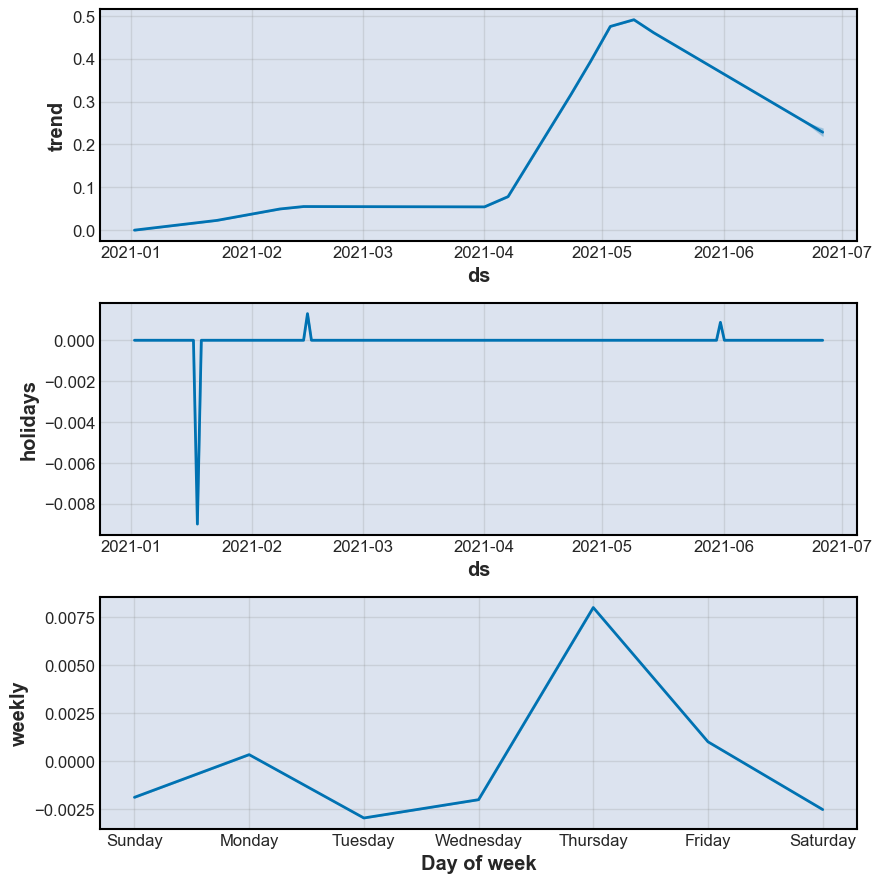

In [10]:
m = Prophet(changepoint_prior_scale=.7)
m.add_country_holidays(country_name='US')
m.fit(price_predict_df);
m.train_holiday_names

future = m.make_future_dataframe(periods=7)

forecast = m.predict(future)
fig = m.plot_components(forecast)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

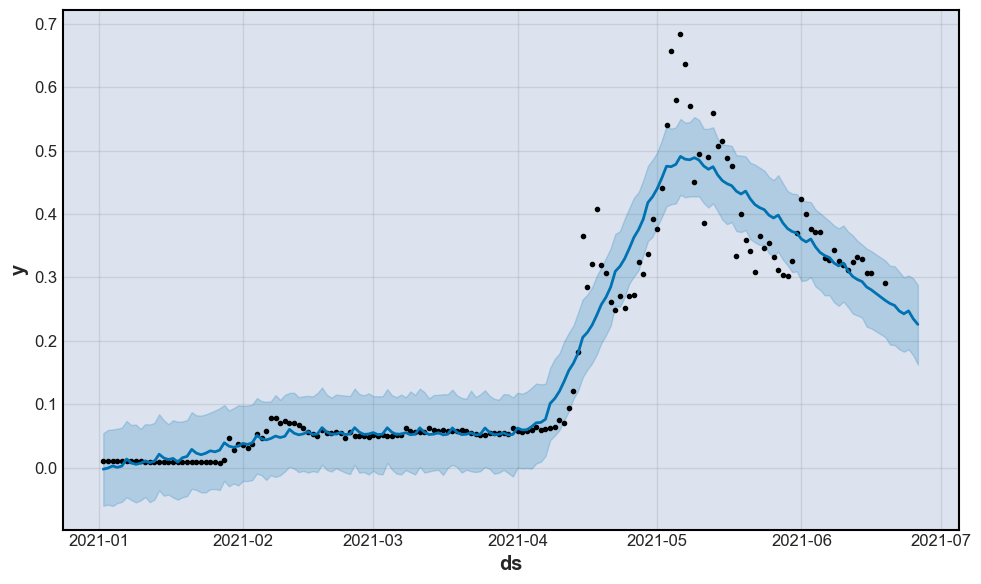

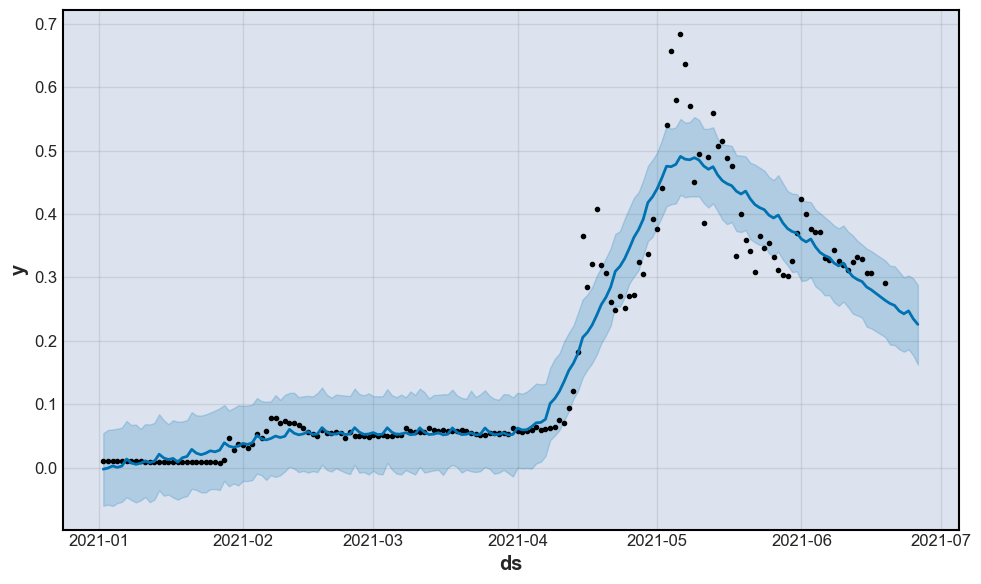

In [11]:
m.plot(forecast)

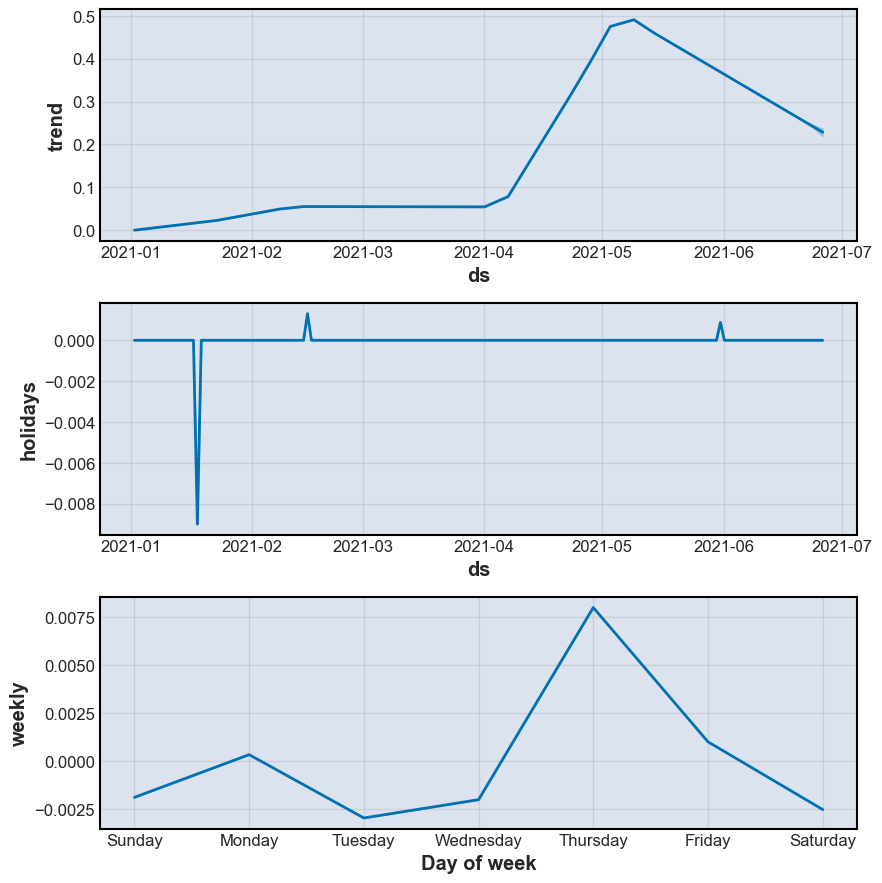

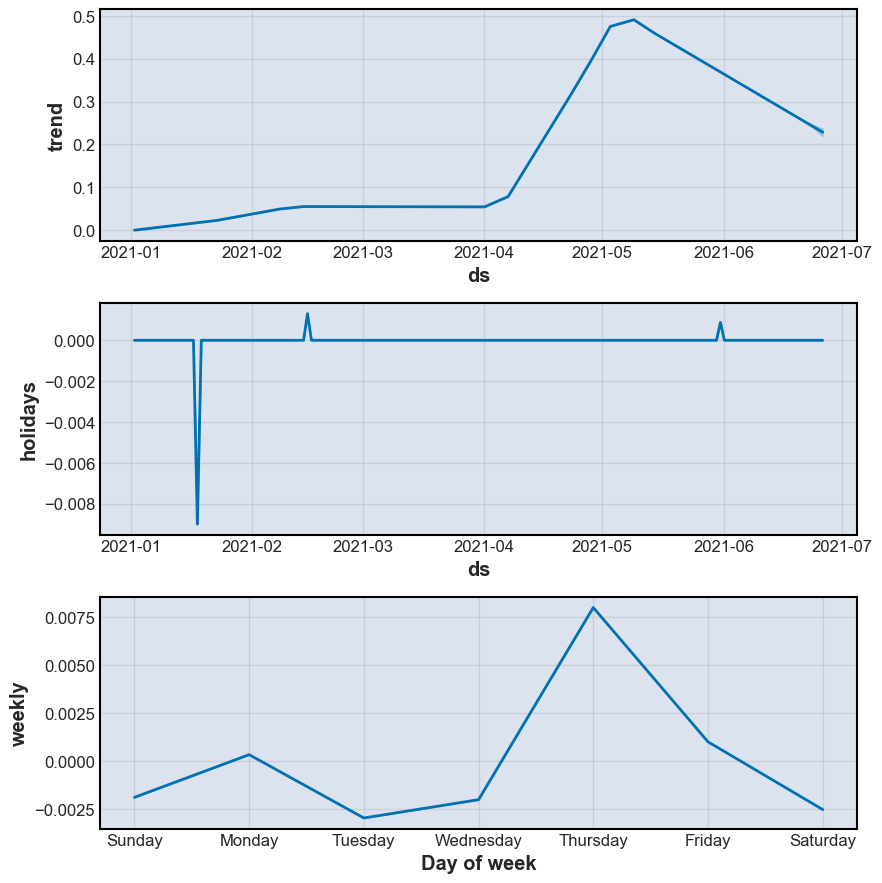

In [12]:
m.plot_components(forecast)